In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from typing import Tuple

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from tqdm.auto import tqdm

tqdm.pandas()
pd.options.display.max_columns = None

In [3]:
# !jupyter labextension uninstall jupyterlab_vim

In [4]:
# configure user
user = "jonas"  # set this to mitchel

if user.lower() == "jonas":
    BASE_PATH = "/users/jonvdrdo/jonas/data/aaa_contextaware/raw/uz_study/"
elif user.lower() == "mitchel":
    BASE_PATH = "D:/Data/EEG_Study_1/"  # Go check 1_audio_preprocess.py
DATA_PATH = BASE_PATH + "aligned_data"

if user.lower() == "jonas":
    FEATURES_PATH = ""  # + "/features_gemaps/"
elif user.lower() == "mitchel":
    FEATURES_PATH = DATA_PATH + "/features/"

In [5]:
def parse_timeline_marker_file(df_timeline, df_marker) -> Tuple[pd.DataFrame, ...]:
    tz = "europe/brussels"
    for c in ["t_start", "t_stop"]:
        df_timeline[c] = pd.to_datetime(df_timeline[c]).dt.tz_convert(tz)
    for c in ["timestamp"]:
        df_marker[c] = pd.to_datetime(df_marker[c]).dt.tz_convert(tz)

    # 2. assert whether the start-time of the timeline file is sorted
    df_timeline = df_timeline.sort_values(by=["t_start", "Trial"])
    assert df_timeline["t_start"].is_monotonic_increasing
    return df_timeline, df_marker


cbs = [
    condition + str(block)
    for condition in ["Controle", "Stress"]
    for block in [1, 2, 3]
]


def get_block_dataframe(df_timeline) -> pd.DataFrame:
    cb_dict = {"block": [], "t_start": [], "t_end": []}
    for cb in cbs:
        cb_mask = df_timeline.Phase.str.startswith(cb)
        df_cb = df_timeline[cb_mask].sort_values(by="t_start").reset_index()
        t_start, t_end = df_cb.t_start.iloc[:: len(df_cb) - 1]
        t_end += pd.Timedelta(seconds=6)

        cb_dict["block"].append(cb)
        cb_dict["t_start"].append(t_start)
        cb_dict["t_end"].append(t_end)

    return pd.DataFrame(cb_dict)

In [6]:
df_log_sex = pd.read_csv("sex_mapping.csv")
df_log_sex.sample(3)

,user,sex
59,60,F
45,46,M
61,62,F


In [7]:
block_list = []

for p in tqdm(sorted(Path(DATA_PATH).iterdir())):
    if not p.is_dir():
        continue

    # -------------- edf_aligned ----------------
    timeline_file = p.joinpath("timeline_aligned.csv")
    marker_file = p.joinpath("marker_edf_aligned.csv")
    if timeline_file.exists() and marker_file.exists():
        edf_source = "edf_aligned"

        # 1. if both files exists, read them and parse the time columns
        df_timeline = (
            pd.read_csv(timeline_file).iloc[:, 1:].drop(columns=["OnsetDelay.1"])
        )
        df_marker = pd.read_csv(marker_file).iloc[:, 1:]
        df_timeline, df_marker = parse_timeline_marker_file(df_timeline, df_marker)

        df_block = get_block_dataframe(df_timeline)

        # add the rest EEG block
        for start_name, end_name, block_name in [
            ("Rest EEG start", "Rest EEG end", "EEG_rest"),
            ("Stress recovery start", "Stress recovery end", "Stress_recovery"),
            ("Control recovery start", "Control recovery end", "Control_recovery"),
        ]:
            df_block = df_block.append(
                {
                    "t_start": df_marker[df_marker.action == start_name].timestamp.iloc[
                        0
                    ],
                    "t_end": df_marker[df_marker.action == end_name].timestamp.iloc[0],
                    "block": block_name,
                },
                ignore_index=True,
            )

        df_block["user"] = p.name
        df_block["sex"] = df_log_sex[df_log_sex.user == int(p.name)]["sex"].values[0]
        df_block["edf_source_dir"] = edf_source

        block_list.append(df_block)
        continue

    # ------------------------ marker-aligned ---------------------------
    timeline_file = p.joinpath("timeline.csv")
    marker_file = p.joinpath("marker_edf.csv")
    if timeline_file.exists() and marker_file.exists():
        edf_source = "edf"

        # Read the files and parse the columns
        df_timeline = pd.read_csv(timeline_file).drop(columns=["OnsetDelay.1"])
        df_marker = pd.read_csv(marker_file)
        df_timeline, df_marker = parse_timeline_marker_file(df_timeline, df_marker)

        # align the timeline file to the marker file
        timeline_feedback_times = (
            df_timeline[df_timeline.Phase.str.lower().str.contains("feedback")]
            .reset_index()
            .t_start
        )
        marker_feedback_times = (
            df_marker[df_marker.action.str.lower().str.contains("feedback")]
            .reset_index()
            .timestamp
        )
        df_timeline[["t_start", "t_stop"]] += (
            marker_feedback_times - timeline_feedback_times
        ).median()

        # 4. filter on the feedback events
        df_block = get_block_dataframe(df_timeline)

        for start_name, end_name, block_name in [
            ("Rest EEG start", "Rest EEG end", "EEG_rest"),
            ("Stress recovery start", "Stress recovery end", "Stress_recovery"),
            ("Control recovery start", "Control recovery end", "Control_recovery"),
        ]:
            df_block = df_block.append(
                {
                    "t_start": df_marker[df_marker.action == start_name].timestamp.iloc[
                        0
                    ],
                    "t_end": df_marker[df_marker.action == end_name].timestamp.iloc[0],
                    "block": block_name,
                },
                ignore_index=True,
            )

        df_block["user"] = p.name
        df_block["sex"] = df_log_sex[df_log_sex.user == int(p.name)]["sex"].values[0]
        df_block["edf_source_dir"] = edf_source

        block_list.append(df_block)

# construct the feedback dataframe
df_block = pd.concat(block_list, ignore_index=True, axis=0)
df_block

  0%|          | 0/85 [00:00<?, ?it/s]

,block,t_start,t_end,user,sex,edf_source_dir
0,Controle1,2020-02-03 10:16:20.430047+01:00,2020-02-03 10:23:04.634047+01:00,10,F,edf
1,Controle2,2020-02-03 10:24:02.313047+01:00,2020-02-03 10:29:02.708047+01:00,10,F,edf
2,Controle3,2020-02-03 10:29:51.904047+01:00,2020-02-03 10:35:12.064047+01:00,10,F,edf
3,Stress1,2020-02-03 10:49:32.300047+01:00,2020-02-03 10:54:55.826047+01:00,10,F,edf
4,Stress2,2020-02-03 10:55:54.955047+01:00,2020-02-03 11:01:12.749047+01:00,10,F,edf
...,...,...,...,...,...,...
670,Stress2,2020-01-31 13:51:39.907688+01:00,2020-01-31 13:56:41.519688+01:00,9,F,edf
671,Stress3,2020-01-31 13:57:13.532688+01:00,2020-01-31 14:02:32.226688+01:00,9,F,edf
672,EEG_rest,2020-01-31 12:55:33.224609+01:00,2020-01-31 13:05:33.269531+01:00,9,F,edf
673,Stress_recovery,2020-01-31 14:03:12.966797+01:00,2020-01-31 14:13:13.009766+01:00,9,F,edf


In [8]:
# ------------------- HYPERPARAMS -------------------
min_r_peak_threshold = 0.85  # minimum r-peak agreement threshold to still use the data

# ---------------- The algorithm ------------------
# iterate over all the users in the feedback file
slcs = []
for user in tqdm(df_block.user.unique()):
    df_b_user = df_block[df_block.user == user]

    # fetch the correct feedback RR_interval data (matching timestamps)
    f_path = Path(DATA_PATH).joinpath(user, df_b_user.edf_source_dir.values[0])
    f_path = list(f_path.glob("rr_intervals_*.parquet"))
    if len(f_path) != 1:
        print(f"skipping user {user} f_path size {len(f_path)}")
        continue

    rr_file_user = pd.read_parquet(f_path[0]).set_index("timestamp")

    for idx, r in df_b_user.iterrows():
        slc = rr_file_user[r.t_start : r.t_end].copy().reset_index()

        # do not use slices with lower
        if slc["r_peak_agreement"].mean() < min_r_peak_threshold:
            print(f"skipping slice user - {r.user} - {r.block} - {len(slc)}")
            continue

        # add a relative time col w.r.t. event and feedback_index which will be used
        # to link the data back to df_feedback
        slc["feedback_index"] = idx
        slc["user"] = r.user
        slc["block"] = r.block

        # determine the int-ibi pos
        slcs.append(slc)

df_slc = pd.concat(slcs, axis=0, ignore_index=True)
del slcs

  0%|          | 0/75 [00:00<?, ?it/s]

skipping slice user - 11 - Controle1 - 310
skipping slice user - 11 - Controle2 - 335
skipping slice user - 11 - Controle3 - 358
skipping slice user - 11 - Stress1 - 364
skipping slice user - 11 - Stress2 - 309
skipping slice user - 11 - Stress3 - 316
skipping slice user - 11 - EEG_rest - 634
skipping slice user - 11 - Stress_recovery - 632
skipping slice user - 11 - Control_recovery - 704
skipping slice user - 15 - Controle2 - 357
skipping slice user - 15 - Controle3 - 448
skipping slice user - 15 - Stress2 - 371
skipping slice user - 15 - EEG_rest - 735
skipping slice user - 17 - Controle1 - 796
skipping slice user - 17 - Stress1 - 626
skipping slice user - 17 - Stress2 - 571
skipping user 18 f_path size 0
skipping slice user - 35 - Controle1 - 474
skipping slice user - 35 - Controle2 - 383
skipping slice user - 35 - Controle3 - 347
skipping slice user - 35 - Stress1 - 339
skipping slice user - 35 - Stress2 - 354
skipping slice user - 35 - Stress3 - 368
skipping slice user - 35 - EEG

In [9]:
group = df_slc.groupby(["user", "block"])

# RMSSD

In [10]:
from hrvanalysis import get_frequency_domain_features, get_time_domain_features

In [11]:
len_feat = group["RR_interval_ms"].apply(lambda x: len(x.dropna())).rename("N")

# frequency domain features
fdf = (
    group["RR_interval_ms"]
    .apply(
        lambda x: get_frequency_domain_features(x.dropna().values, method="lomb")
        if len(x.dropna()) > 100
        else None
    )
    .rename("fdfs")
)
fdf = (
    fdf.to_frame()
    .reset_index()
    .pivot(index=["user", "block"], columns="level_2", values="fdfs")
)

# time domain features
tdf = (
    group["RR_interval_ms"]
    .apply(
        lambda x: get_time_domain_features(x.dropna())
        if len(x.dropna()) > 100
        else None
    )
    .rename("tdfs")
)
tdf = (
    tdf.to_frame()
    .reset_index()
    .pivot(index=["user", "block"], columns="level_2", values="tdfs")
)

In [12]:
df_hrv_feats = pd.concat([tdf, len_feat, fdf], axis=1)
df_hrv_feats["total_power_div_N"] = df_hrv_feats["total_power"] / df_hrv_feats["N"]

In [13]:
df_hrv_feats.to_parquet("df_hrv_feats.parquet")

In [14]:
import matplotlib.pyplot as plt

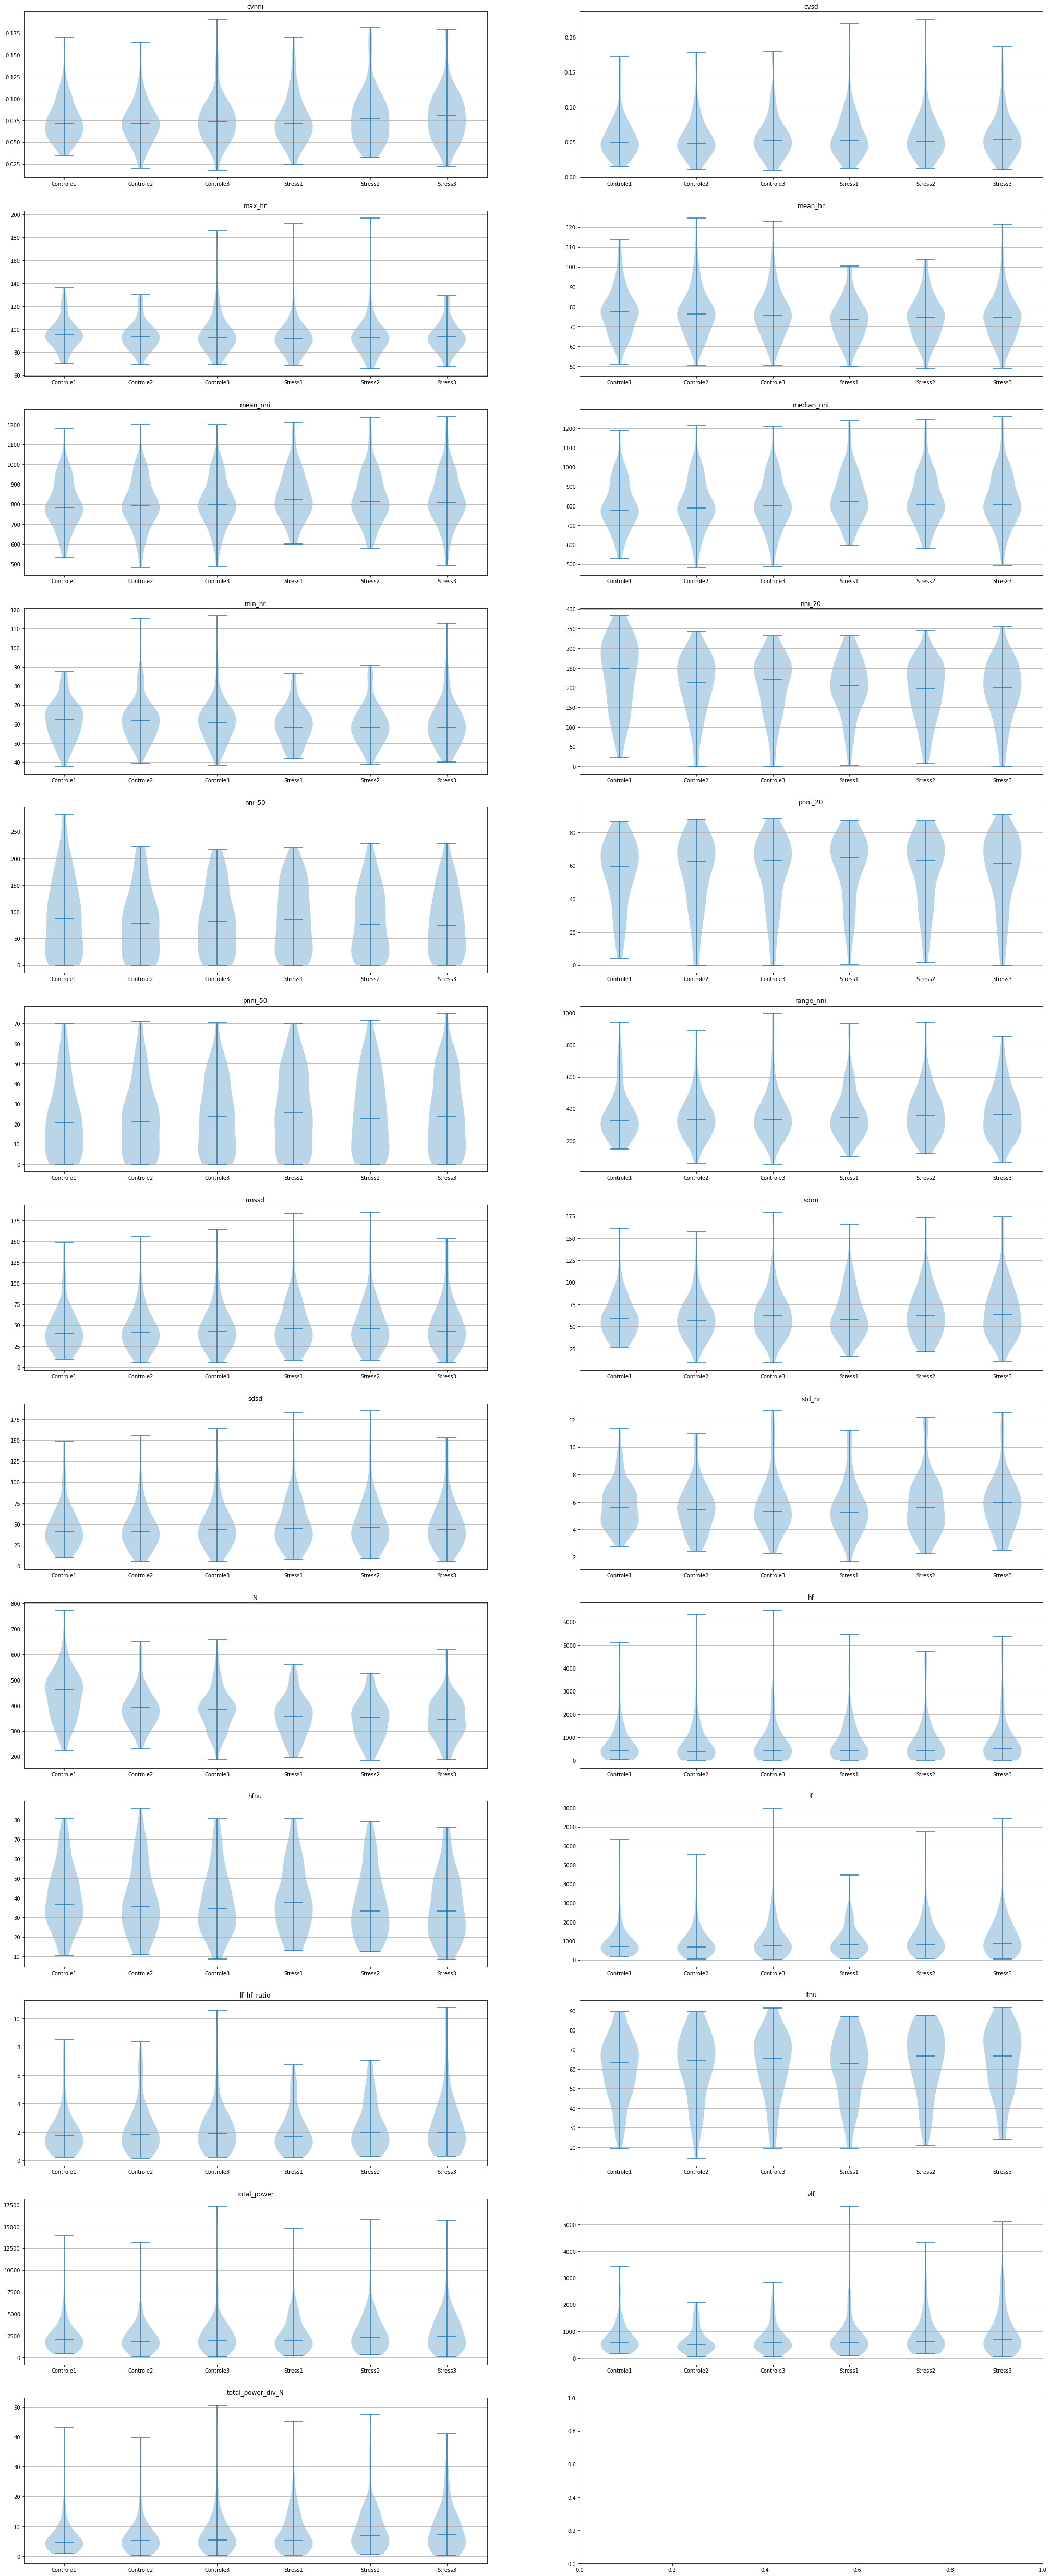

In [17]:
ncols = 2
fig, axs = plt.subplots(
    nrows=df_hrv_feats.shape[1] // ncols + (df_hrv_feats.shape[1] % ncols != 0),
    ncols=ncols,
    figsize=(35,90),
)

groups = [
#     "EGG_rest",
    "Controle1",
    "Controle2",
    "Controle3",
#     "Control_recovery",
    "Stress1",
    "Stress2",
    "Stress3",
#     "Stress_recovery",
]

for i, c in enumerate(df_hrv_feats.columns):
    data = [
        df_hrv_feats.loc[pd.IndexSlice[:, g], c]
        for g in groups
    ]
    row = i // ncols
    col = i % ncols
    ax = axs[row, col]
    ax.violinplot(data, showmedians=True)
    ax.set_title(c)
    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(len(groups))], labels=groups)

plt.show()